In [2]:
!conda install -c conda-forge jaxlib jax

/bin/bash: line 1: conda: command not found


In [8]:
import os
import numpy as np
import pandas as pd
from pathlib import Path


import matplotlib.pyplot as plt, matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
import warnings

In [10]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
warnings.filterwarnings('ignore')

In [16]:
img_size = 128
batch_size = 32

base_dir = Path("/content/drive/MyDrive/Colab Notebooks/blood_cell_images_split_90_10")
train_path = base_dir / "train"
val_path = base_dir / "val"

print("Train directories:", os.listdir(train_path))
print("Validation directories:", os.listdir(val_path))

Train directories: ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']
Validation directories: ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']


In [17]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_path,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=False
)

Found 4500 files belonging to 5 classes.
Found 500 files belonging to 5 classes.


In [18]:
class_names = train_dataset.class_names
print("Class names:", class_names)

Class names: ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']


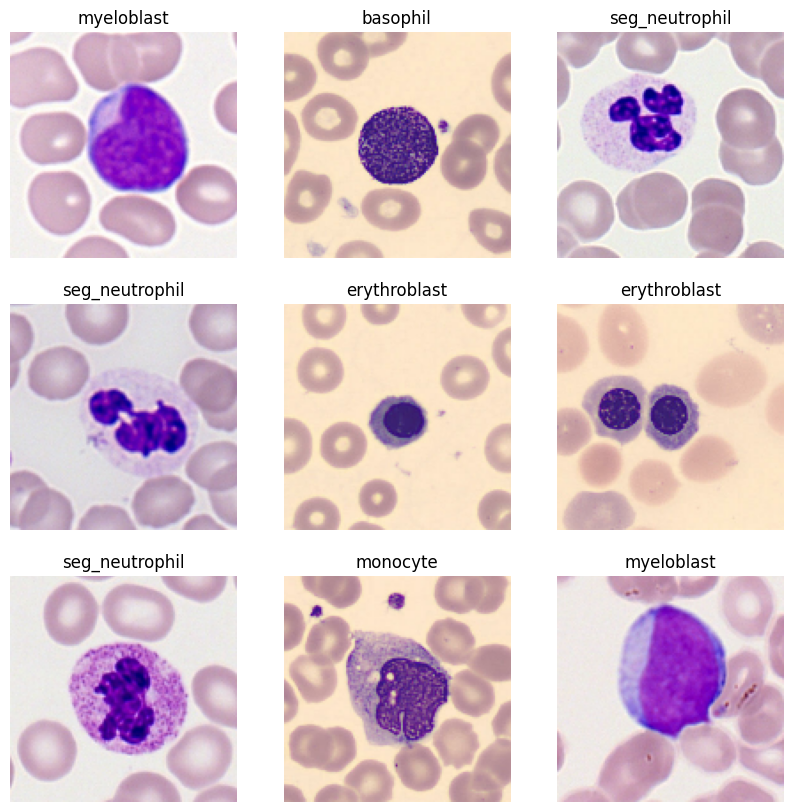

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 128
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=str(train_path),
    target_size=(img_size, img_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=str(val_path),
    target_size=(img_size, img_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


(128, 128, 1)


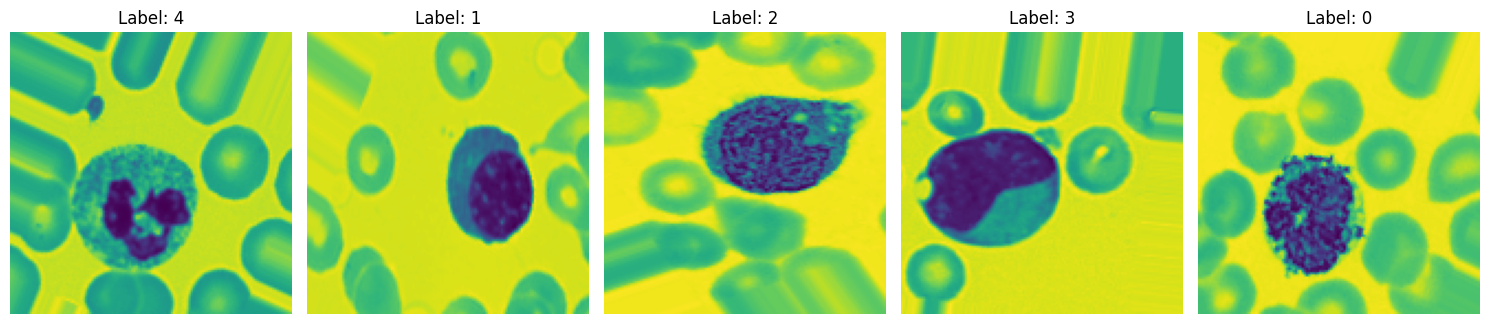

In [29]:
# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Number of images to display
num_images = min(len(images), 5)

# Create a figure and subplots
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Iterate over the images and display them
for i in range(num_images):
    axes[i].imshow(images[i])
    axes[i].set_title(f"Label: {labels[i].argmax()}") # Display predicted class
    axes[i].axis('off')

print(images[0].shape)
plt.tight_layout()
plt.show()

In [30]:
def create_model(input_shape=(128, 128, 1)):
    """
    Create a CNN model with fixed architecture

    Args:
        input_shape: Shape of input images, default (128, 128, 1)

    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Flatten and dense layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_model(model, train_generator, val_generator, epochs=30):
    """
    Train the model with early stopping and learning rate reduction

    Args:
        model: Compiled Keras model
        train_generator: Training data generator
        val_generator: Validation data generator
        epochs: Maximum number of epochs to train

    Returns:
        Training history and trained model
    """
    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        )
    ]

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )

    return history, model

def plot_training_history(history):
    """
    Plot training history including accuracy and loss curves

    Args:
        history: Keras training history object
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix with class labels

    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    # Define class labels
    class_labels = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

def print_classification_metrics(y_true, y_pred):
    """
    Print classification report with class labels

    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    class_labels = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

    report = classification_report(
        y_true,
        y_pred,
        target_names=class_labels,
        digits=4
    )
    print("\nClassification Report:")
    print(report)

def evaluate_model(model, test_generator):
    """
    Evaluate the model on test data

    Args:
        model: Trained Keras model
        test_generator: Test data generator

    Returns:
        Test loss, accuracy, and predicted classes
    """
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

    # Get predictions
    predictions = model.predict(test_generator)
    predicted_classes = predictions.argmax(axis=1)

    return test_loss, test_accuracy, predicted_classes

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# Define parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10

# Create and compile model
print("Creating model...")
model = create_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
model.summary()

# Train model
print("\nTraining model...")
history, trained_model = train_model(
    model,
    train_generator,
    val_generator,
    epochs=EPOCHS
)

# Evaluate model
print("\nEvaluating model...")
final_val_accuracy = history.history['val_accuracy'][-1]
print(f'Final validation accuracy: {final_val_accuracy:.4f}')

Creating model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,661 (24.87 MB)

 Trainable params: 6,517,701 (24.86 MB)

 Non-trainable params: 960 (3.75 KB)


Training model...
Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.5550 - loss: 1.4942 - val_accuracy: 0.2000 - val_loss: 10.1581 - learning_rate: 0.0010
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.8504 - loss: 0.4481 - val_accuracy: 0.2000 - val_loss: 8.6458 - learning_rate: 0.0010
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.8829 - loss: 0.3431 - val_accuracy: 0.2000 - val_loss: 8.2043 - learning_rate: 0.0010
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.9145 - loss: 0.2641 - val_accuracy: 0.3080 - val_loss: 5.7318 - learning_rate: 0.0010
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.9173 - loss: 0.2668 - val_accuracy: 0.5900 - val_loss: 2.3234 - learning_rate: 0.0010
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.9308 - loss: 0.2018 - val_accuracy: 0.2940 - val_loss: 11.3116 - learning_rate: 0.0010
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accura

In [27]:
print("Train classes:", os.listdir(train_path))
print("Val classes:", os.listdir(val_path))

Train classes: ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']
Val classes: ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']


In [ ]:
# Plot results
print("\nPlotting results...")
plot_training_history(history)

In [ ]:
# Get true labels from test generator
y_true = test_generator.classes

# Plot confusion matrix
plot_confusion_matrix(y_true, predictions)
print_classification_metrics(y_true, predictions)

In [ ]:
def show_random_predictions(model, test_generator):
    """
    Display 3x3 grid of random test images with predictions.
    """
    # Labels for our classes
    labels = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

    # Create 3x3 subplot
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for i in range(3):
        for j in range(3):
            # Get a random batch and image from test generator
            batch_x, batch_y = next(test_generator)
            idx = random.randint(0, len(batch_x)-1)
            img = batch_x[idx]
            true_label = np.argmax(batch_y[idx])

            # Get prediction
            pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
            pred_label = np.argmax(pred)

            # Determine text color (Green if correct, Red if wrong)
            color = 'green' if true_label == pred_label else 'red'

            # Plot image
            axes[i, j].imshow(np.squeeze(img), cmap='gray')
            axes[i, j].set_title(
                f'True: {labels[true_label]}\nPred: {labels[pred_label]}',
                color=color, fontsize=12, fontweight='bold'
            )
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Use it with your model:
show_random_predictions(trained_model, test_generator)